In [1]:
!pip install transformers

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import DistilBertModel, DistilBertTokenizer


In [3]:
df = pd.read_csv('/content/augmented_data (1).csv')
df.head()

,Questions,Blooms Taxonomy
0,Given is an array after the first partition of...,remember
1,How many steps are required to solve Tower of ...,remember
2,How many comparisons are required to find elem...,remember
3,"Given an array A[-3:4, 6:10], Find the address...",remember
4,"Consider the following list of 10 numbers: 35,...","apply , remember"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2808 entries, 0 to 2807
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Questions        2808 non-null   object
 1   Blooms Taxonomy  2808 non-null   object
dtypes: object(2)
memory usage: 44.0+ KB


In [5]:
# Convert 'Understanding' to 'Understand' in 'Column_with_Understanding'
df['Blooms Taxonomy'] = df['Blooms Taxonomy'].replace('Understanding', 'understand')

print(df['Blooms Taxonomy'])

0               remember
1               remember
2               remember
3               remember
4       apply , remember
              ...       
2803             Analyze
2804             Analyze
2805              Create
2806              Create
2807              Create
Name: Blooms Taxonomy, Length: 2808, dtype: object


In [6]:
word_to_encoding = {
    'remember': 0,
    'understand': 1,
    'apply': 2,
    'analyze': 3,
    'evaluate': 4,
    'create': 5
}

def map_words_to_encoding(words):
    words = [word.strip().lower() for word in words.split(',')]
    encoding_values = [word_to_encoding[word] for word in words if word in word_to_encoding]
    return max(encoding_values) if encoding_values else 0


df['encoded_values'] = df['Blooms Taxonomy'].apply(map_words_to_encoding)

print(df)

                                              Questions   Blooms Taxonomy  \
0     Given is an array after the first partition of...          remember   
1     How many steps are required to solve Tower of ...          remember   
2     How many comparisons are required to find elem...          remember   
3     Given an array A[-3:4, 6:10], Find the address...          remember   
4     Consider the following list of 10 numbers: 35,...  apply , remember   
...                                                 ...               ...   
2803  Analyze the interpretability of different topi...           Analyze   
2804  Analyze the performance of a text classificati...           Analyze   
2805  Design a natural language processing pipeline ...            Create   
2806  Develop a sentiment analysis model that can cl...            Create   
2807  Develop a text classification model that can i...            Create   

      encoded_values  
0                  0  
1                  0  
2     

### **Data Preparation**

In [7]:
df['encoded_values'] = df['encoded_values'].astype(int)

In [8]:
df['encoded_values'].value_counts()

1    584
5    518
0    482
3    460
2    382
4    382
Name: encoded_values, dtype: int64

In [49]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [50]:
token = tokenizer.encode_plus(
    df['Questions'].iloc[0],
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)

In [51]:
token.input_ids

<tf.Tensor: shape=(1, 256), dtype=int32, numpy=
array([[  101, 10470,  1110,  1126,  9245,  1170,  1103,  1148, 16416,
         1104,  3613, 21484,  1204,   131,   124,   117,   121,   117,
          123,   117,   125,   117,  1275,   117,   129,   117,   128,
          117,   127,   117,   130,   119,  5979,  1104,  1103,  5290,
         1180,  1129,  1103,   185, 15435,  1204,   136,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

In [52]:
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))

In [53]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['Questions'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [54]:
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

In [55]:
labels = np.zeros((len(df), 6))
labels.shape

(2808, 6)

In [56]:
labels[np.arange(len(df)), df['encoded_values'].values] = 1 # one-hot encoded target tensor

In [57]:
labels

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [58]:
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [59]:
def qualityDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [60]:
dataset = dataset.map(qualityDatasetMapFunction) # converting to required format for tensorflow dataset

In [61]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(6,), dtype=tf.float64, name=None))>

In [62]:
dataset = dataset.shuffle(10000).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [63]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 6), dtype=tf.float64, name=None))>

In [64]:
p = 0.8
train_size = int((len(df)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

In [65]:
train_size

140

In [66]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

### **Model**

In [27]:
from transformers import TFDistilBertModel

In [67]:
model = TFDistilBertModel.from_pretrained('distilbert-base-cased') # bert base model with pretrained weights

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [68]:
import tensorflow as tf
from transformers import TFDistilBertModel

distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

distilbert_output = distilbert_model(input_ids, attention_mask=attn_masks)

last_hidden_states = distilbert_output.last_hidden_state

pooled_output = tf.reduce_mean(last_hidden_states, axis=1)

intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(pooled_output)
output_layer = tf.keras.layers.Dense(6, activation='softmax', name='output_layer')(intermediate_layer)

blooms_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
blooms_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model_6 (TF  TFBaseModelOutput(last_hid   6636288   ['input_ids[0][0]',           
 DistilBertModel)            den_state=(None, 256, 768)   0          'attention_mask[0][0]']      
                             , hidden_states=None, atte                                     

In [35]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')


In [37]:
blooms_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [38]:
hist = blooms_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50
)

Epoch 1/50
140/140 [==============================] - 71s 452ms/step - loss: 1.4620 - accuracy: 0.4143 - val_loss: 1.1324 - val_accuracy: 0.5268
Epoch 2/50
140/140 [==============================] - 63s 447ms/step - loss: 0.9904 - accuracy: 0.6277 - val_loss: 0.7641 - val_accuracy: 0.7411
Epoch 3/50
140/140 [==============================] - 63s 450ms/step - loss: 0.7449 - accuracy: 0.7312 - val_loss: 0.5130 - val_accuracy: 0.8304
Epoch 4/50
140/140 [==============================] - 63s 451ms/step - loss: 0.5420 - accuracy: 0.8196 - val_loss: 0.3083 - val_accuracy: 0.9125
Epoch 5/50
140/140 [==============================] - 63s 449ms/step - loss: 0.3580 - accuracy: 0.8848 - val_loss: 0.1639 - val_accuracy: 0.9643
Epoch 6/50
140/140 [==============================] - 63s 446ms/step - loss: 0.2306 - accuracy: 0.9357 - val_loss: 0.1088 - val_accuracy: 0.9714
Epoch 7/50
140/140 [==============================] - 63s 449ms/step - loss: 0.1655 - accuracy: 0.9500 - val_loss: 0.0583 - val_ac

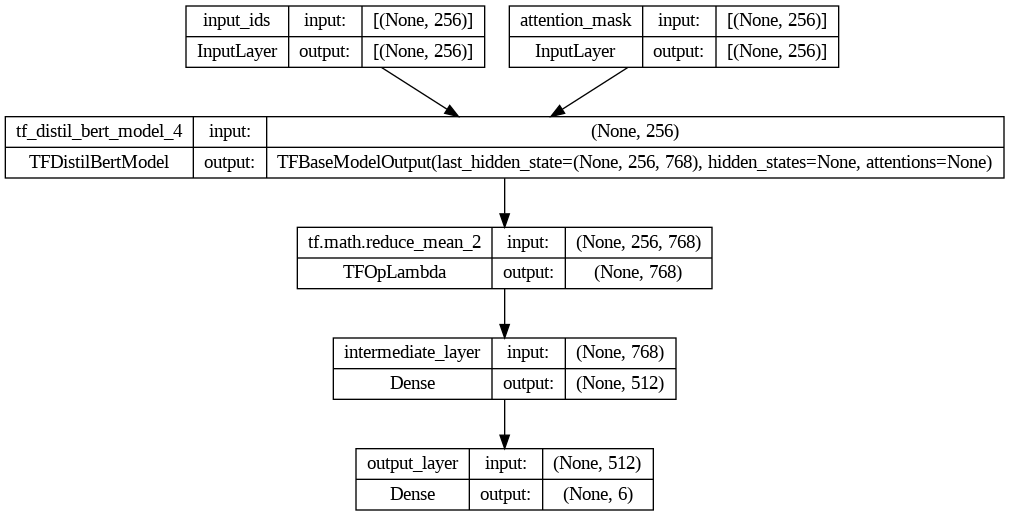

In [39]:
from tensorflow.keras.utils import plot_model
plot_model(blooms_model, to_file='blooms_model.png', show_shapes=True, show_layer_names=True)

In [40]:
blooms_model.save('blooms_model')

In [42]:
blooms_model.evaluate(val_dataset)

35/35 [==============================] - 5s 129ms/step - loss: 0.0296 - accuracy: 0.9821


[0.02964351512491703, 0.9821428656578064]

### **Prediction**

In [78]:
# Assuming you have already trained the model and saved it as 'blooms_model'
from transformers import DistilBertTokenizer
import numpy as np
import tensorflow as tf

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

def prepare_data(input_text, tokenizer):
    tokenized_text = tokenizer.encode_plus(
        input_text,
        max_length=256,
        truncation=True,
        padding='max_length',
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(tokenized_text['input_ids'], tf.float64),
        'attention_mask': tf.cast(tokenized_text['attention_mask'], tf.float64)
    }

def make_prediction(model, processed_data, classes=['remember', 'understand', 'apply', 'analyze', 'evaluate', 'create']):
    probs = blooms_model.predict(processed_data)[0]
    predicted_class = classes[np.argmax(probs)]
    return predicted_class



In [82]:
# Assuming you have already trained the model and saved it as 'blooms_model'
from transformers import DistilBertTokenizer
import numpy as np
import tensorflow as tf

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

# Example input text
new_input_text = "evaluate a text classification model that can identify fake news."

# Tokenize the input text
tokenized_text = tokenizer.encode_plus(
    new_input_text,
    max_length=256,
    truncation=True,
    padding='max_length',
    add_special_tokens=True,
    return_tensors='tf'
)

# Create numpy arrays for input_ids and attention_mask
new_input_ids = tokenized_text['input_ids']
new_attention_mask = tokenized_text['attention_mask']

# Make predictions
predictions = blooms_model.predict({'input_ids': new_input_ids, 'attention_mask': new_attention_mask})

# Convert predictions to probabilities
probabilities = tf.nn.softmax(predictions).numpy()

# Print the probabilities
print(probabilities)
